# Project

# Introduction

## Contributions

## Table of Contents

## Dataset

# Setup of Environment

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd
import datetime as dt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn import metrics

ModuleNotFoundError: No module named 'matplotlib'

## Extract the data

In [68]:
plant_1_gen = pd.read_csv("Plant_1_Generation_data.csv")
plant_2_gen = pd.read_csv("Plant_2_Generation_data.csv")
plant_1_wea = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
plant_2_wea = pd.read_csv("Plant_2_Weather_Sensor_data.csv")

# Data Exploration

## Check columns for missing values


### Plant 1

In [9]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [10]:
plant1_wea = plant_1_wea.isnull().sum()
print(plant1_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


### Plant 2

In [7]:
plant2_info = plant_2_gen.isnull().sum()
print(plant2_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


### Weather 2

In [8]:
plant2_wea = plant_2_wea.isnull().sum()
print(plant2_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [ ]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

## How many sensors are at each plant?

In [12]:
print("Plant 1 has",plant_1_gen['SOURCE_KEY'].nunique(),"sensors")
print("Plant 2 has",plant_2_gen['SOURCE_KEY'].nunique(),"sensors")

Plant 1 has 22 sensors
Plant 2 has 22 sensors


In [105]:
#Data for 34 days and continuous dates
numb_daws = pd.to_datetime(plant_1_gen['DATE_TIME']).dt.date.unique()

len(numb_daws) # TODO : check continuity
pd.date_range(start = '2020-5-15', end = '2020-6-17').difference(plant_1_gen.index)

DatetimeIndex(['2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
               '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03',
               '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07',
               '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
               '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
               '2020-06-16', '2020-06-17'],
              dtype='datetime64[ns]', freq='D')

#### Some inverters have more data points then the others

In [ ]:
#Inverterids
print("Plant 1 statistics \n", plant_1_gen.SOURCE_KEY.value_counts())
print("Plant 2 statistics \n", plant_2_gen.SOURCE_KEY.value_counts())

Plant 1 statistics 
 bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
iCRJl6heRkivqQ3    3125
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
zVJPv84UY57bAof    3124
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64
Plant 2 statistics 
 vOuJvMaM2sgwLmb    3259
PeE6FRyGXUgsRhN    3259
WcxssY2VbP4hApt    3259
LlT2YUhhzqhg5Sw    3259
xoJJ8DcxJEcupym    3259
LYwnQax7tkwH5Cb    3259
oZZkBaNadn6DNKz    3259
rrq4fwE8jgrTyWY    3259
9kRcWv60rDACzjR    3259
V94E5Ben1TlhnDV    3259
q49J1IKaHRwDQnt    3259
81aHJ1q11NBPMrL    3259
oZ35aAeoifZaQzV    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6

## Data visualization

### **Convert datetime column to datetime format**

In [69]:
#Plant 1 weather data
plant_1_wea['DATE_TIME'] = pd.to_datetime(plant_1_wea['DATE_TIME']) 
plant_1_wea['TIME'] = plant_1_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_1_wea['DATE'] = pd.to_datetime(plant_1_wea['DATE_TIME'].dt.date)
print(plant_1_wea['DATE'])

#Plant 2 weather data
plant_2_wea['DATE_TIME'] = pd.to_datetime(plant_2_wea['DATE_TIME']) 
plant_2_wea['TIME'] = plant_2_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_2_wea['DATE'] = pd.to_datetime(plant_2_wea['DATE_TIME'].dt.date)


0      2020-05-15
1      2020-05-15
2      2020-05-15
3      2020-05-15
4      2020-05-15
          ...    
3177   2020-06-17
3178   2020-06-17
3179   2020-06-17
3180   2020-06-17
3181   2020-06-17
Name: DATE, Length: 3182, dtype: datetime64[ns]


### **Analysis of weather dataset for both the plants**

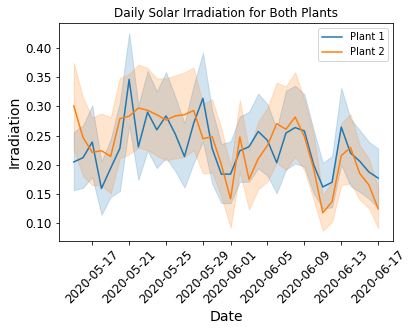

Mean of solar irradition from Plant1 0.22831283006565126
Mean of solar irradition from Plant2 0.23273697972872914


In [70]:
# Comparing both plants
# Daily Irradiation
ambient_compare = sns.lineplot(x='DATE', y='IRRADIATION', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='IRRADIATION', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambient_compare)
plt.ylabel('Irradiation')
plt.xlabel('Date')
plt.title('Daily Solar Irradiation for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of solar Irradiation for both plants are similar
mean_irradiationplant1 = plant_1_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant1', mean_irradiationplant1)
mean_irradiationplant2 =  plant_2_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant2', mean_irradiationplant2)

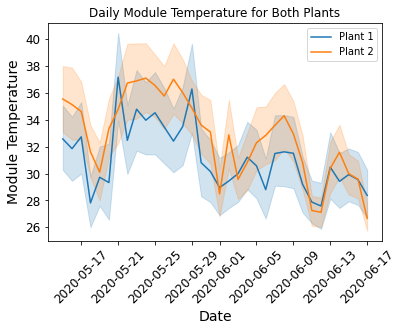

Mean of Module Temperature from Plant1 31.091015378426377
Mean of Module Temperature from Plant2 32.77240792902497


In [23]:
# Daily Module Temperature
modtemp_compare = sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=modtemp_compare)
plt.ylabel('Module Temperature')
plt.xlabel('Date')
plt.title('Daily Module Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of Module Temperature for both plants (Plant 1 is lower then Plant 2)
mean_moduletempplant1 = plant_1_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_moduletempplant1)
mean_moduletempplant2 =  plant_2_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_moduletempplant2)


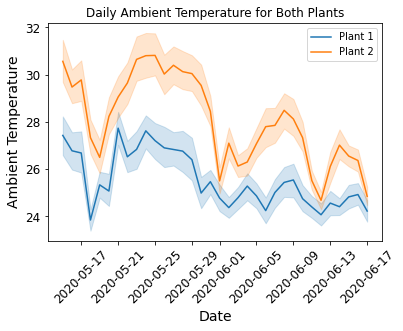

Mean of Ambient Temperature from Plant1 25.53160571756439
Mean of Ambient Temperature from Plant2 28.069399882321143


In [24]:
ambtemp_compare = sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambtemp_compare)
plt.ylabel('Ambient Temperature')
plt.xlabel('Date')
plt.title('Daily Ambient Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()


# The mean of Ambient Temperature for both plants (Plant 1 is lower then Plant 2)
mean_ambienttempplant1 = plant_1_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant1', mean_ambienttempplant1)
mean_ambienttempplant2 =  plant_2_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant2', mean_ambienttempplant2)

#### Observations

1. The mean solar irradiation values for both plants are similar.
2. The mean module temperature of Plant 1 is  lower than Plant 2 most of the time.
3. The mean ambient temperature of Plant 1 is much lower than Plant 2.


## Data cleaning


#### Transform and merge the datasets

##### Drop unwanted columns.

In [71]:
df_weather1 = plant_1_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant1 = plant_1_gen.drop(['PLANT_ID'], axis=1)
df_weather2 = plant_2_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant2 = plant_2_gen.drop(['PLANT_ID'], axis=1)

In [97]:
df_plant1["Human_key"] = df_plant1["SOURCE_KEY"].map({val: f"S{i+1}" for i, val in enumerate(df_plant1["SOURCE_KEY"].unique())})
df_plant1.sample(20)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Human_key
43351,2020-06-05 21:45:00,bvBOhCH3iADSZry,0.000000,0.000000,7065.000000,6467251.000,S11
42314,2020-06-05 09:30:00,zBIq5rxdHJRwDNY,9141.571429,893.385714,1285.857143,6493864.857,S20
37809,2020-06-03 05:30:00,ih0vzX44oOqAx2f,0.000000,0.000000,0.000000,6321311.000,S13
1002,2020-05-15 11:30:00,adLQvlD726eNBSB,8083.857143,790.200000,2365.142857,6273720.143,S10
1022,2020-05-15 11:45:00,ZnxXDlPa8U1GXgE,9124.625000,891.112500,2454.500000,6524626.500,S8
65907,2020-06-16 14:45:00,bvBOhCH3iADSZry,6194.857143,606.957143,4762.857143,6532554.857,S11
5358,2020-05-17 16:30:00,wCURE6d3bPkepu2,4061.750000,398.575000,7228.250000,6802698.250,S18
62492,2020-06-15 00:00:00,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7254584.000,S7
52857,2020-06-10 10:30:00,YxYtjZvoooNbGkE,7216.375000,706.175000,1854.500000,7375122.500,S22
54667,2020-06-11 07:00:00,ih0vzX44oOqAx2f,771.125000,74.800000,33.250000,6381065.250,S13


In [78]:
#Formatedattime
df_plant1['DATE_TIME']= pd.to_datetime(df_plant1['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_weather1['DATE_TIME']= pd.to_datetime(df_weather1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
#df_plant1.head()
df_plant2['DATE_TIME']= pd.to_datetime(df_plant2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_weather2['DATE_TIME']= pd.to_datetime(df_weather2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

In [79]:
df_plant_weather1 = df_plant1.merge(df_weather1, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather2 = df_plant2.merge(df_weather2, left_on='DATE_TIME', right_on='DATE_TIME')

print(df_plant_weather1.head())
print(df_plant_weather2.head())

   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

  Human_key  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION      TIME  \
0        S1            25.184316           22.857507          0.0  00:00:00   
1        S2            25.184316           22.857507          0.0  00:00:00   
2        S3            25.184316           22.857507          0.0  00:00:00   
3        S4            25.184316           22.857507          0.0  00:00:00   
4        S5            25.184316           22.857507          0.0  00:00:00   

        DATE  
0 2020-05-15  
1 2020-05-15  
2 202

### Imputation

## Data Analysis

### **Data Correlation Analysis**


Observations:
1. High correlation between DC Power and AC power generation
2. High correlation between DC Power and IRRADIATION
3. Strong correlation between DC Power, AC Power and Module Temperature and Ambient Temperature

In [80]:
corr_matrix = df_plant_weather1.corr()

corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.989391
MODULE_TEMPERATURE     0.954811
AMBIENT_TEMPERATURE    0.724668
DAILY_YIELD            0.082243
TOTAL_YIELD            0.003851
Name: DC_POWER, dtype: float64

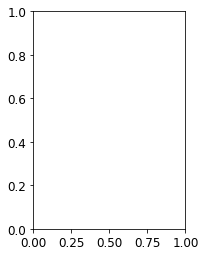

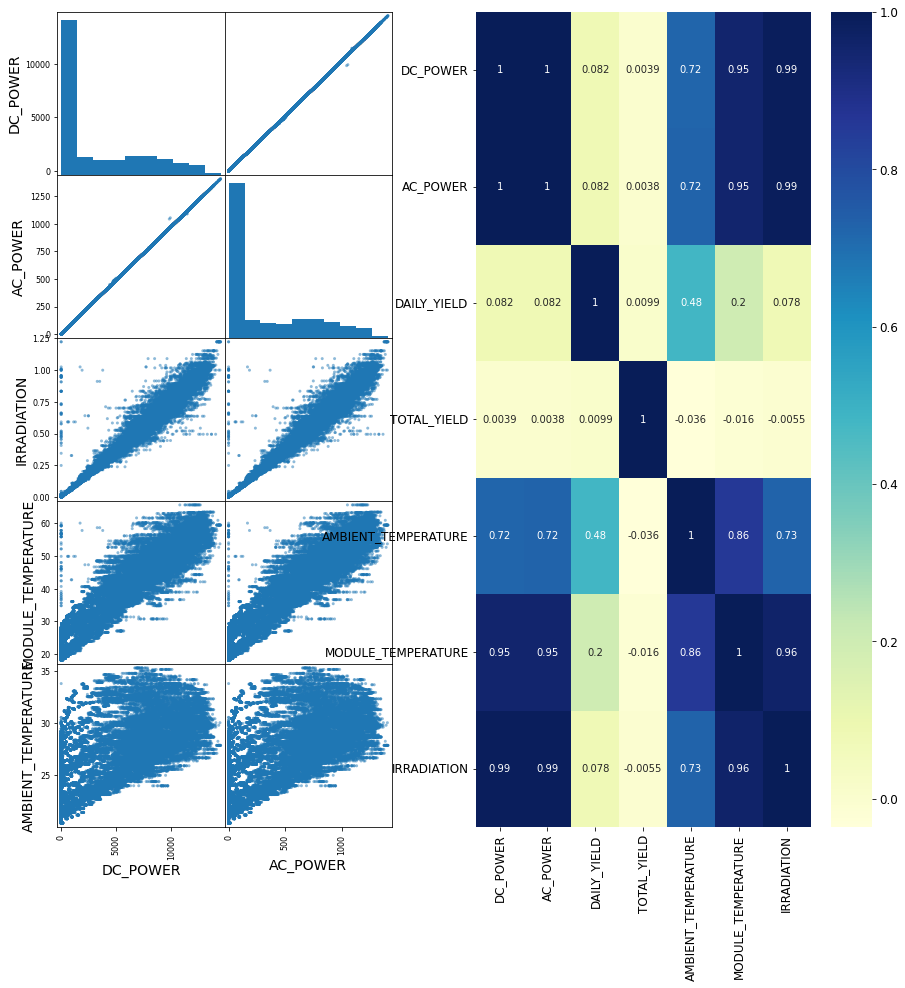

In [104]:
attributes = ["DC_POWER", "AC_POWER", "IRRADIATION",
              "MODULE_TEMPERATURE","AMBIENT_TEMPERATURE"]

plt.subplot(1, 2, 1)
scatter_plot = scatter_matrix(df_plant_weather1[attributes], figsize=(15, 15))

plt.subplot(1, 2, 2)
fig_corr = sns.heatmap(corr_matrix,cmap="YlGnBu", annot=True) # TODO - subplot + margin

**Analysis of DC power generated from each Source Keys.**
1. TheDistribution DC power generation plot shows multiple occasion where power generated was zero during daytime.
2.  plot of solar irradiation exhibits that the solar radiation never dropped to a lower value at day time. 
3. Analysis shows some inverters received no DC power even through there was enough sunlight
4. It could be concluded that the DC power generated and solar irradiation has a linear relationship.

### **Stacked Visualization of Power Generation**

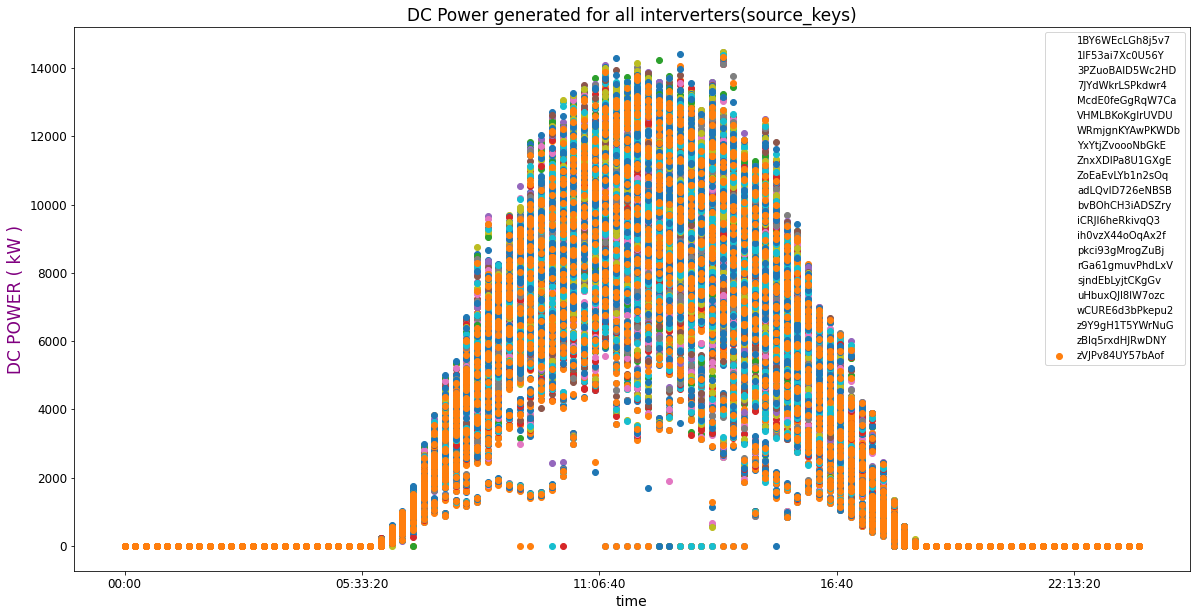

In [98]:
#DC power generated from each source keys
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power generated for all interverters(source_keys)',size=17)
plt.ylabel('DC POWER ( kW )',color='purple',fontsize=17)
plt.show()

                        mean  min          max      median       SOURCE_KEY  \
SOURCE_KEY                                                                    
1BY6WEcLGh8j5v7  2873.720981  0.0  13335.14286  302.955357  1BY6WEcLGh8j5v7   
1IF53ai7Xc0U56Y  3225.125523  0.0  14302.71429  450.526786  1IF53ai7Xc0U56Y   
3PZuoBAID5Wc2HD  3221.015673  0.0  14351.12500  456.160714  3PZuoBAID5Wc2HD   
7JYdWkrLSPkdwr4  3132.891955  0.0  14204.00000  438.571429  7JYdWkrLSPkdwr4   
McdE0feGgRqW7Ca  3211.307245  0.0  14418.42857  439.571429  McdE0feGgRqW7Ca   

                   mean_new  
SOURCE_KEY                   
1BY6WEcLGh8j5v7 -273.745332  
1IF53ai7Xc0U56Y   77.659209  
3PZuoBAID5Wc2HD   73.549359  
7JYdWkrLSPkdwr4  -14.574358  
McdE0feGgRqW7Ca   63.840931  


<AxesSubplot:xlabel='SOURCE_KEY'>

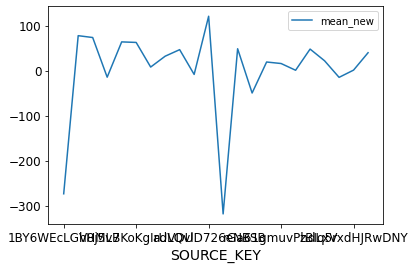

In [61]:
#Inverters with lower performace then rest "1BY6WEcLGh8j5v7", "bvBOhCH3iADSZry"
SOURCE = df_plant_weather1.groupby('SOURCE_KEY').agg({'DC_POWER': ['mean', 'min', 'max','median']})['DC_POWER']
SOURCE["SOURCE_KEY"] = SOURCE.index
mean = SOURCE['mean'].mean()
SOURCE["mean_new"] = SOURCE['mean'] - mean
print(SOURCE.head())

SOURCE.plot(x="SOURCE_KEY", y="mean_new")

## Research

Solar power plants generate a vast amount of data which can be used to determine how a plant is performing and what is impacting its performance. Taking this a step further, a plant’s performance can be optimized by leveraging advanced analytics. Advanced analytics includes formulating statistical matrices, implementing actionable performance alarms, and conducting artificial intelligent models to predict future performance. A relatively accurate energy prediction can be calculated by incorporating weather forecasts, a plant’s historical performance
This method requires substantial computing power and considerable time to develop accurate predictions. To illustrate this, this project will attempt to analyze power generation data in tandem with weather data to predict near-future (days) performance with data gathered from two solar power plants in India over a 34-day period.


### Select features of interest / Problem Statement

Prediction of power generation in coming days using different ML techniques

### Choose an appropriate ML model based on the dataset and your problem statement.

# ML Techniques

Linear Regression
From the data analysis and corerelation analsysis it was inferred that there is a linear relation between the DC power generated andthe solar irradiation. This relation can be modeled using a simple linear relationship as below,
𝑃(𝑡) = 𝑎 + 𝑏 . 𝐸(𝑡) where p(t) denotes the power generated and the E(t) denotes the solar irradiation. So we will run a linear regression model on our datasets.

### Model 1: Linear Regression for Plant 1 dataset

In [ ]:
X1=df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features 
y1=df_plant_weather1['DC_POWER'] # independent var / predictor

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X1_train.shape)
print("Y Train Shape = ",y1_train.shape)
print("X Test Shape  = ",X1_test.shape)
print("Y Test Shape  = ",y1_test.shape)

In [ ]:
lm = LinearRegression()

Fit on training data

In [ ]:
lm.fit(X1_train, y1_train)
lm.intercept_, lm.coef_

(89.01209177219363, array([-40.38940184,  40.04138528]))

In [ ]:
print ('Plant 1 linear regression cofficients are:', X.columns, lm.coef_ )
print('Plant 1 intercept', lm.intercept_)

Plant 1 linear regression cofficients are: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object') [-40.38940184  40.04138528]
Plant 1 intercept 89.01209177219363


Prediction from model

In [ ]:
Prediction_plant1 = lm.predict (X1_test)
Prediction_plant1
Y1_pred_train = lm.predict(X1_train)
Y1_pred_test = lm.predict(X1_test)

print ('Prediction Train dataset', Y1_pred_train)
print ('Prediction Train dataset', Y1_pred_test)

Prediction Train dataset [319.24148263 -10.89915161 -11.61392072 ... -24.88904315   2.28030868
 617.23637436]
Prediction Train dataset [1075.8099964    38.91509271   37.92676015 ...  -14.0049295   -12.73072717
  342.26548549]


Actual Solar Output Values vs Predicted Values for Plant 1 using Linear Regression (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

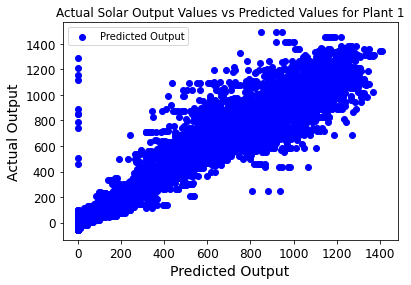

In [ ]:

plt.scatter(y1_test, Y1_pred_test,color="b", label="Predicted Output")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1 dataset)

In [ ]:
print("Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)")
print("")
RMSE_train_1 = np.sqrt( metrics.mean_squared_error(y1_train, Y1_pred_train))
RMSE_test_1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
MAE1 = metrics.mean_absolute_error(y1_test, Y1_pred_test)
MSE1 = metrics.mean_squared_error(y1_test, Y1_pred_test)
RMSE1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('RMSE for training set = {}'.format(round(RMSE_train_1,2)))
print('RMSE for test set = {}'.format(round(RMSE_test_1,2)))
print('MAE: ', MAE1)
print('MSE: ',MSE1)
print('RMSE: ', RMSE1)
print()

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)

RMSE for training set = 94.06
RMSE for test set = 92.88


### Model 1 : Linear Regression for Plant 2 dataset

In [ ]:
X12=df_plant_weather2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION']] # Features 
y12=df_plant_weather2['AC_POWER'] # independent var / predictor

X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X12_train.shape)
print("Y Train Shape = ",y12_train.shape)
print("X Test Shape  = ",X12_test.shape)
print("Y Test Shape  = ",y12_test.shape)

Shape of each Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [ ]:
lm = LinearRegression()

Fit on training data for Plant 2

In [ ]:

lm.fit(X12_train, y12_train)
lm.intercept_, lm.coef_

(-158.9063334664413, array([  14.31914096,   -7.34317926, 1042.77770477]))

Prediction from model

In [ ]:
Prediction_plant2 = lm.predict (X12_test)
Prediction_plant2
Y12_pred_train = lm.predict(X12_train)
Y12_pred_test = lm.predict(X12_test)

print ('Prediction Train dataset', Y12_pred_train)
print ('Prediction Train dataset', Y12_pred_test)

Prediction Train dataset [720.42986988  14.6652878  869.63077043 ... 892.70017547 437.47378379
 660.91339571]
Prediction Train dataset [667.09310044 489.01766501 724.92861871 ... 680.98490577  38.4763396
  25.58443371]


Actual Solar Output Values vs Predicted Values for Plant 2 using Linear Regression (This also includes faulty days dataset)

In [5]:
plt.scatter(y12_test, Y12_pred_test,color="b", label="Predicted Output")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

NameError: name 'plt' is not defined

Accuracy score for Plant 2 using Linear Regression

In [ ]:
train_score_12 = lm.score(X12_train, y12_train)
test_score_12 = lm.score(X12_test, y12_test)

print("Model 1 Plant 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_12*100,0),"%")
print("Test Score  = ",round(test_score_12*100,0), "%")

Model 1 Plant 2 accuracy score: 

Train Score =  62.0 %
Test Score  =  61.0 %


### Model 2: Random Forest for Plant2 dataset 

Select columns that will be used to create train and test dataset

In [ ]:
model_2 = df_plant_weather2
model_2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,00:00:00,2020-05-15


In [ ]:
X2 = model_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']] # Features
y2 = model_2['AC_POWER'] # Target

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.20, random_state=1) 

print("Shape of each New Dataset : ")
print("X Train Shape = ",X2_train.shape)
print("Y Train Shape = ",y2_train.shape)
print("X Test Shape  = ",X2_test.shape)
print("Y Test Shape  = ",y2_test.shape)

Shape of each New Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [ ]:

RF = RandomForestRegressor()
RF.fit(X2_train, y2_train)

RandomForestRegressor()

In [ ]:
y2_pred_train = RF.predict(X2_train)
y2_pred_test = RF.predict(X2_test)

Model Evaluation for Random Forest

In [ ]:
print("Model Evaluation for Random Forest Model 2 using RMSE")

RMSE_train_2 = np.sqrt( metrics.mean_squared_error(y2_train, y2_pred_train))
RMSE_test_2 = np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_test))
MSE_train_2 = ( metrics.mean_squared_error(y2_train, y2_pred_train))
print('RMSE for training set is {}'.format(round(RMSE_train_2,2)))
print('RMSE for test set is {}'.format(round(RMSE_test_2,2)))
print('MSE for train set is {}'.format(round(MSE_train_2,2)))

Model Evaluation for Random Forest Model 2 using RMSE
RMSE for training set is 193.54
RMSE for test set is 211.12
MSE for train set is 37456.04


Accuracy score for Model 2

In [ ]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  71.0 %
Test Score  =  66.0 %


Actual Solar Output Values vs Predicted Values for Plant 2 using Random Forest Regresor (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

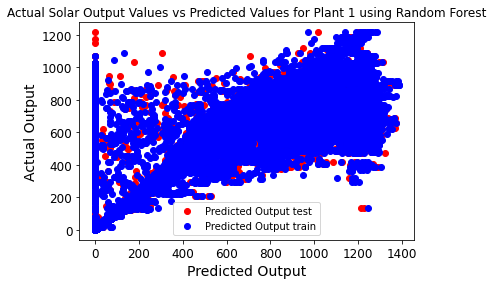

In [ ]:
# This also includes faulty days dataset
plt.scatter(y2_test, y2_pred_test,color="r", label="Predicted Output test")
plt.scatter(y2_train, y2_pred_train,color="b", label="Predicted Output train")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1 using Random Forest')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

Feature Scaling

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X2_train)
X_test = sc.transform(X2_test)

Running the model after Feature scaling

In [ ]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X2_train, y2_train)
y3_pred = regressor.predict(X2_test)


Accuracy scorefor Model 2 after scaling data

In [ ]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  71.0 %
Test Score  =  66.0 %



Tune the parameters of your model. 
Make predictions regarding the future values for some of your chosen variables. 

 Evaluate your model based on different metrics. 

 - R2, 
 - MSE,
 - RSME,
 - Cross validation

# References